In [1]:
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.nn import relu

import pandas as pd
import matplotlib.pyplot as plt

## Training parameters

In [2]:
# limit of input data size
rows_limit = 40000

# which features and label to consider
selected_features = ['dates', 'categories', 'vectors', 'tfidf'] # ['dates', 'categories', 'vectors', 'tfidf']
selected_label = 'replies_cat'

# min count for idf
min_count = 100

# features selection
select_method = 'percents' # 'percents'
no_features = 10000
features_percentile = 70

#       ['replies', 'upvotes', 'downvotes', 'rage', 'joy', 'sadness', 'surprise',
#        'fear', 'reactions', 'reactions_sentiment', 'replies_cat',
#        'upvotes_cat', 'downvotes_cat', 'reactions_cat',
#        'reactions_sentiment_cat', 'rage_cat', 'joy_cat', 'sadness_cat',
#        'surprise_cat', 'fear_cat']

## Data reading

In [3]:
df = pd.read_csv('labeling/fresh_data.csv', nrows = rows_limit)\
    .set_index('id')\
    .drop_duplicates(keep = 'first')
df = df.drop(['title', 'highlight', 'content', 'media_desc'], axis = 1)

In [4]:
df.head(3)

,div,date,author,media_type,replies,upvotes,downvotes,rage,joy,sadness,surprise,fear,reactions,reactions_sentiment
id,,,,,,,,,,,,,,
24247530,dekomunizacja ulic,2018-12-06 13:00:00,Jarosław Osowski,image,7,44,1,0,2,0,0,2,45,0.98
24593465,CBA,2019-03-28 13:40:00,mch,image,3,9,0,0,0,0,0,0,9,1.00
24376781,Kraj,2019-01-18 14:17:00,Antonio Tajani,image,28,567,10,0,3,0,0,8,577,0.98


## Data preparation

In [5]:
labels_columns = ['replies', 'upvotes', 'downvotes', 'rage', 'joy', 'sadness', 'surprise', 
                  'fear', 'reactions', 'reactions_sentiment']
labels_df = df[[selected_label.split('_')[0]]]
df = df.drop(labels_columns, axis = 1)

In [6]:
def process_dates(df):
    df['date'] = pd.to_datetime(df['date'])
    df = pd.concat([
        df,
        pd.get_dummies(df['date'].dt.weekday, prefix = 'weekday'),
        pd.get_dummies(df['date'].dt.hour, prefix = 'hour'),
    ], axis = 1)
    return df

In [7]:
if 'dates' in selected_features:
    df = process_dates(df)
df = df.drop('date', axis = 1)

In [8]:
df.shape

(35233, 34)

In [9]:
def process_author_div_and_media_type(df):
    df = pd.concat([
        df,
        pd.get_dummies(df['author'], prefix = 'author'),
        pd.get_dummies(df['div'], prefix = 'div'),
        pd.get_dummies(df['media_type'], prefix = 'media_type')
    ], axis = 1)
    return df

In [10]:
if 'categories' in selected_features:
    df = process_author_div_and_media_type(df)
df = df.drop(['author', 'div', 'media_type'], axis = 1)

In [11]:
df.head(3)

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,div_żuławski tulipan,div_żuławy,div_żużel,div_żydzi,div_żydzi w warszawie,div_żywność,div_żłobki,media_type_image,media_type_multiple_images,media_type_video
id,,,,,,,,,,,,,,,,,,,,,
24247530,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24593465,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24376781,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
df.shape

(35233, 5346)

In [13]:
def add_vectors(columns, index, labels_df):
    column_vectors = []
    pca_dict = {}
    for column in columns:
        tmp = pd.read_csv('labeling/'+column+'_vec').set_index('id').reindex(index)
        pca = PCA(n_components = 50)
        pca.fit(tmp.values, labels_df.values)
        tmp_values = pca.transform(tmp.values)
        tmp = pd.DataFrame(tmp_values, index = index)
        tmp.columns = [column+"_"+str(x) for x in range(len(tmp.columns))]
        column_vectors.append(tmp)
        pca_dict[column] = pca
    return pd.concat(column_vectors, axis = 1), pca_dict

In [14]:
if 'vectors' in selected_features:
    vectors, pca_vectors = add_vectors(['content', 'highlight', 'title', 'media_desc'], df.index, labels_df)
    df = pd.concat([df, vectors], axis = 1)

In [15]:
df.head(5)

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,media_desc_40,media_desc_41,media_desc_42,media_desc_43,media_desc_44,media_desc_45,media_desc_46,media_desc_47,media_desc_48,media_desc_49
id,,,,,,,,,,,,,,,,,,,,,
24247530,0,0,0,1,0,0,0,0,0,0,...,0.060539,-0.045988,-0.028613,-0.021673,-0.108907,-0.121419,-0.194868,0.179873,0.118019,-0.071842
24593465,0,0,0,1,0,0,0,0,0,0,...,0.003256,-0.008506,0.005305,-0.004176,0.006897,-0.001665,0.002028,-0.003006,0.000743,0.000209
24376781,0,0,0,0,1,0,0,0,0,0,...,-0.177734,0.016111,-0.028542,0.260670,-0.133619,0.277242,-0.034611,-0.019221,0.021813,-0.003731
22852664,0,0,1,0,0,0,0,0,0,0,...,0.091256,0.070146,-0.033802,-0.030717,0.184107,0.038662,0.182734,-0.274962,-0.067590,-0.075275
24320164,1,0,0,0,0,0,0,0,0,0,...,-0.107859,0.139476,0.000490,-0.094070,0.050592,-0.190580,0.023143,-0.147432,0.059520,0.099639


In [16]:
df.shape

(35233, 5546)

In [17]:
from json import load
import numpy as np
from collections import Counter

In [18]:
with open('labeling/idf_dict', 'r') as f:
    idf = {key: value for key, value in load(f).items() if value >= min_count}
    idf_voc = idf.keys()

In [19]:
lemmas = pd.read_csv('labeling/lemmatized_articles.csv', nrows = rows_limit).set_index('id').fillna('')

In [20]:
lemmas.head(1)

,content,highlight,media_desc,title
id,,,,
24247530,piatkowej wokanda nsa figurowac nazwa stoleczn...,naczelny sad administracyjny rozny finalizowac...,marzec zakladanie nowy tablica dawny al armia ...,czas wyczekiwac final dekomunizacja ulica piat...


In [21]:
def add_tf_idf(columns, index, labels_df):
    whole_string = ''
    for column in columns:
        whole_string = whole_string + lemmas[column] + ' '
    tf_idf = []
    for record in whole_string.values:
        return_record = []
        counts = dict(Counter(record.split(' ')))
        for feature_word in idf_voc:
            if feature_word in counts.keys():
                return_record.append(counts[feature_word]/idf[feature_word])
            else:
                return_record.append(0)
        tf_idf.append(return_record)
        
    tmp = pd.DataFrame(tf_idf, index = index)
    pca = PCA(n_components = int(len(tmp.columns)*0.2))
    pca.fit(tmp.values, labels_df.values)
    tmp_values = pca.transform(tmp.values)
    tmp = pd.DataFrame(tmp_values, index = index)
    tmp.columns = ['tf_idf_'+str(x) for x in range(len(tmp.columns))]
    
    return tmp, pca

In [22]:
if 'tfidf' in selected_features:
    tfidf_col, tfidf_pca = add_tf_idf(['content', 'highlight', 'title', 'media_desc'], df.index, labels_df)
    df = pd.concat([df, tfidf_col], axis = 1)

In [23]:
df.shape

(35233, 6905)

In [24]:
labels_df.shape

(35233, 1)

## Categorize labels

In [25]:
import matplotlib.pyplot as plt

63.0


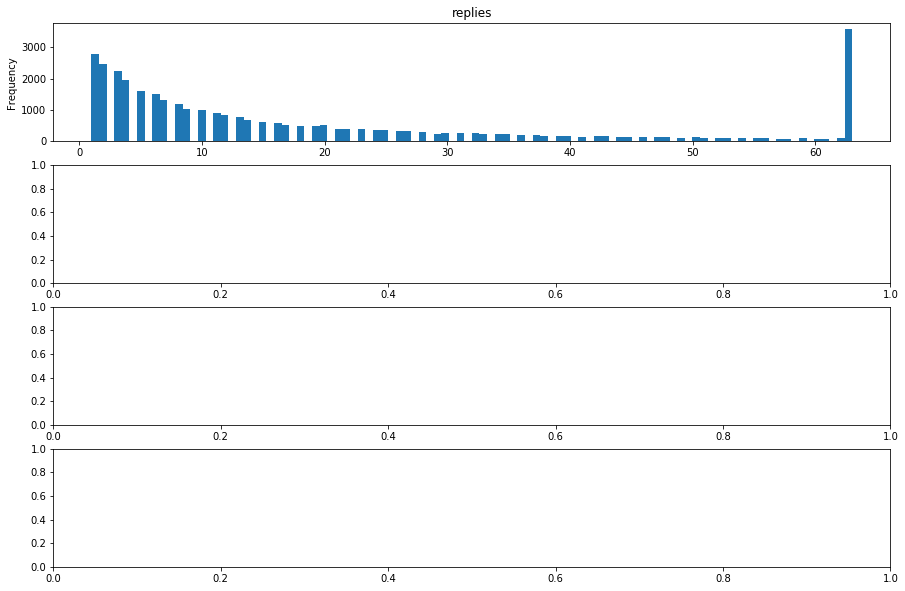

In [26]:
fig, axes = plt.subplots(4)
for i, column in enumerate(['replies', 'upvotes', 'downvotes', 'reactions']):
    try:
        threshold = labels_df[column].quantile(0.9)
        print(threshold)
        labels_df.loc[labels_df[column] > threshold, column] = threshold
        labels_df[column].plot(kind = 'hist', bins = 100, figsize= (15,10), title = column, ax = axes[i])
    except:
        pass

In [27]:
try:
    labels_df['reactions_sentiment'] = labels_df['reactions_sentiment'].fillna(0)
except:
    pass

In [28]:
categories = []
categories_columns = ['replies', 'upvotes', 'downvotes', 'reactions', 'reactions_sentiment']
for column in categories_columns:
    try:
        categories.append(pd.qcut(labels_df[column], 3, labels = [-1, 0, 1]))
    except:
        pass
try:
    tmp_cat = pd.concat(categories, axis = 1)
    tmp_cat.columns = [selected_label.split('_')[0]+"_cat"]
    labels_df = pd.concat([labels_df, tmp_cat], axis = 1)
except:
    pass

In [29]:
labels_df.head(3)

,replies,replies_cat
id,,
24247530,7.0,0
24593465,3.0,-1
24376781,28.0,1


In [30]:
for emotion in ['rage', 'joy', 'sadness', 'surprise', 'fear']:
    try:
        labels_df.loc[labels_df[emotion] == 0, emotion+'_cat'] = 0
        labels_df.loc[labels_df[emotion] != 0, emotion+'_cat'] = 1
    except:
        pass

In [31]:
# fig, axes = plt.subplots(1, 5, figsize = (20,3))
# for i, emotion_cat in enumerate(['rage_cat', 'joy_cat', 'sadness_cat', 'surprise_cat', 'fear_cat']):
#     labels_df[[emotion_cat]].reset_index().groupby(emotion_cat).count().plot(kind = 'bar', ax = axes[i])

### Check for NaN

In [32]:
df[df.isna().any(axis=1)]

,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour_0.0,hour_1.0,hour_2.0,...,tf_idf_1349,tf_idf_1350,tf_idf_1351,tf_idf_1352,tf_idf_1353,tf_idf_1354,tf_idf_1355,tf_idf_1356,tf_idf_1357,tf_idf_1358
id,,,,,,,,,,,,,,,,,,,,,


In [33]:
labels_df[labels_df.isna().any(axis=1)]

,replies,replies_cat
id,,


## Normalize labels

In [34]:
def normalize_labels(df, labels_df, selected_label):
    label_counts = labels_df[[selected_label]]\
        .reset_index()\
        .groupby(selected_label)\
        .count()\
        .sort_values('id')
    
    less_label_name = label_counts\
        .iloc[0]\
        .name
    
    multiplier = round(label_counts.iloc[1].id/label_counts.iloc[0].id)
    
    less_label_df = labels_df[labels_df[selected_label] == less_label_name]
    main_df_less_labels_records = df[df.index.isin(less_label_df.index)]
    
    for i in range(int(multiplier)):
        labels_df = labels_df.append(less_label_df)
        df = df.append(main_df_less_labels_records)
    
    label_counts = labels_df[[selected_label]]\
        .reset_index()\
        .groupby(selected_label)\
        .count()\
        .sort_values('id')\
        .reset_index()
    
    flatten_more = label_counts[label_counts[selected_label] == less_label_name].id.values[0]
    flatten_less = label_counts[label_counts[selected_label] != less_label_name].id.values[0]
    excess = flatten_more - flatten_less
    
    labels_df = labels_df.iloc[:len(labels_df) - excess]
    df = df.iloc[:len(df) - excess]
    
    labels_df = labels_df.reset_index().sample(frac = 1)
    df = df.reset_index().reindex(labels_df.index)
    
    return df, labels_df

In [35]:
if selected_label.split('_')[0] in ('fear', 'sadness', 'joy', 'surprise', 'rage'):
    df, labels_df = normalize_labels(df, labels_df, selected_label)

In [36]:
labels_df[[selected_label]]\
        .reset_index()\
        .groupby(selected_label)\
        .count()\

,id
replies_cat,
-1,12537
0,10982
1,11714


In [37]:
labels_df.shape

(35233, 2)

In [38]:
df.shape

(35233, 6905)

## Features selection

In [39]:
try:
    df = df.drop('id', axis = 1)
    labels_df = labels_df.drop('id', axis = 1)
except:
    pass

In [40]:
X = df.values

In [41]:
Y = labels_df[[selected_label]].values

In [42]:
if select_method == 'kbest':
    clf = SelectKBest(f_classif, k=no_features).fit(X, Y)
elif select_method == 'percents':
    clf = SelectPercentile(f_classif, percentile = features_percentile).fit(X, Y)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
selected_columns = df.columns[clf.get_support()].tolist()

In [44]:
X.shape

(35233, 6905)

In [45]:
X = clf.transform(X)

In [46]:
X.shape

(35233, 4833)

In [47]:
Y.shape

(35233, 1)

## Define X and Y for training/testing

In [48]:
s = int(len(df)*0.95)

In [49]:
s

33471

In [50]:
train_x = X[:s]
train_y = Y[:s]

In [51]:
test_x = X[s:]
test_y = Y[s:]

## Training

In [52]:
inputs = Input(shape = (X.shape[1], ))

In [53]:
hidden_1 = Dense(int(X.shape[1]/20)+60, activation = relu)(inputs)
dropout_1 = Dropout(0.1)(hidden_1)
hidden_2 = Dense(int(X.shape[1]/100)+30, activation = relu)(dropout_1)
dropout_2 = Dropout(0.1)(hidden_2)
hidden_3 = Dense(int(X.shape[1]/500)+5, activation = relu)(dropout_2)

W0805 17:55:24.016846 140012392457984 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [54]:
outputs = Dense(1)(hidden_3)

In [55]:
model = Model(
    inputs = inputs,
    outputs = outputs
)

In [56]:
from tensorflow.keras.optimizers import RMSprop

In [57]:
optimizer = RMSprop(0.0005)

In [58]:
from tensorflow.losses import *

In [59]:
model.compile(
    loss=mean_squared_error,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0805 17:55:24.238105 140012392457984 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [60]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[0.11759391]
 [0.043049  ]
 [0.04758788]
 [0.00932538]
 [0.01066729]]


In [61]:
EPOCHS = 100

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4833)]            0         
_________________________________________________________________
dense (Dense)                (None, 301)               1455034   
_________________________________________________________________
dropout (Dropout)            (None, 301)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 78)                23556     
_________________________________________________________________
dropout_1 (Dropout)          (None, 78)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1106      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15    

In [65]:
history = model.fit(
    train_x, train_y,
    epochs = EPOCHS,
    validation_split = 0.15, 
    verbose = 0,
    callbacks = [early_stop],
)

In [66]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [67]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [68]:
mae

0.63677645

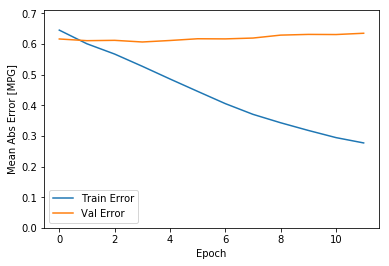

In [69]:
plot_history(history)

In [70]:
res = pd.concat([pd.DataFrame(model.predict(test_x)), pd.DataFrame(test_y)], axis = 1)
res.columns = ['prediction', 'real']
no_categories = len(res['real'].unique())

In [71]:
if no_categories == 2:
    mean = res['prediction'].mean()
    res.loc[res['prediction'] < mean, 'prediction_cat'] = 0
    res.loc[res['prediction'] >= mean, 'prediction_cat'] = 1
elif no_categories == 3:
    res.loc[res['prediction'] < -0.66, 'prediction_cat'] = -1
    res.loc[res['prediction'] >  0.66, 'prediction_cat'] = 1
    res['prediction_cat'] = res['prediction_cat'].fillna(0)

In [72]:
res.loc[res['real'] == res['prediction_cat'], 'if_ok'] = 1
res['if_ok'] = res['if_ok'].fillna(0)

In [73]:
res.sample(frac=1).head(10)

,prediction,real,prediction_cat,if_ok
561,-0.892117,-1,-1.0,1.0
1313,0.060905,1,0.0,0.0
1049,1.049469,1,1.0,1.0
1077,-0.312571,0,0.0,1.0
1588,-0.324397,0,0.0,1.0
1089,-0.832232,0,-1.0,0.0
924,-0.924941,1,-1.0,0.0
807,0.848326,1,1.0,1.0
483,-0.829899,-1,-1.0,1.0
387,-0.033690,0,0.0,1.0


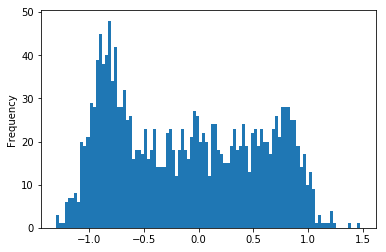

In [74]:
res['prediction'].plot(kind = 'hist', bins = 100)

In [75]:
print('accuracy: ',round(res['if_ok'].sum()/len(res)*100, 2), '%')

accuracy:  46.77 %


In [76]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [77]:
if no_categories == 2:
    c = [0,1]
else:
    c = [-1,0,1]

In [78]:
confusion_data = confusion_matrix(res['real'], res['prediction_cat'])

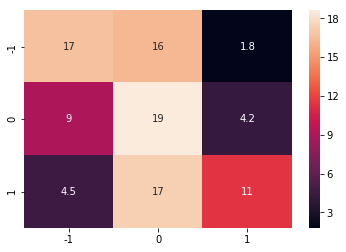

In [79]:
heatmap(np.multiply(np.divide(confusion_data, confusion_data.sum()), 100), xticklabels = c, yticklabels = c, annot=True)

In [80]:
from joblib import dump

In [81]:
# model.save('models/'+selected_label)
# dump(tfidf_pca,'tfidf_pca_'+selected_label)
# dump(pca_vectors,'vectors_pca_'+selected_label)
# dump(clf,'feature_selection_'+selected_label)